##### How do we know which cloud types are 'important' to know?
Specifically, with respect to knowing the cloud fraction, A cloud type with a very distinct cloud fraction (i.e. it's always exactly 0.2) is good to know, because if you can recognize the type, you know the CF. Also, a cloud type that occurs a lot is probably important to recognize (unless it has no useful cloud fraction information). 

So thought experiment: let's pretend you don't know the cloud type, ever. Then your best guess at CF, let's just say, is mean(CF). Now let's pretend you have an oracle that tells you when it's type X, so now when it's X, you guess mean_X(CF), and otherwise it's mean(CF). the reduction in total error tells you how 'useful' it is to know that cloud type.

In [2]:
import sys
sys.path.insert(0, '/home/disk/p/jkcm/Code')
import matplotlib as mpl
import pickle
import seaborn as sns
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils
import pandas as pd

%load_ext autoreload
%autoreload 2

In [3]:
all_sep_df = pd.DataFrame()
for year in ['2014', '2015', '2016']:
    savefile = f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/sep_with_clim_MERRA_{year}.pickle'
    temp_df = pickle.load(open(savefile, 'rb'))
    all_sep_df = pd.concat([all_sep_df, temp_df], ignore_index=True)

In [4]:
sub_df = all_sep_df[['cat', 'lat', 'lon', 'low_cf']]
by_cat = sub_df.groupby('cat')
labels={0: 'Closed-cellular MCC', 1: 'Clustered cumulus', 2: 'Disorganized MCC',
        3: 'Open-cellular MCC', 4: 'Solid Stratus', 5: 'Suppressed Cu'}

In [5]:
sub_df_trop = sub_df[sub_df.lat>-30]

Text(0.5, 0.98, 'SEP |lat|<30 cloud distribution')

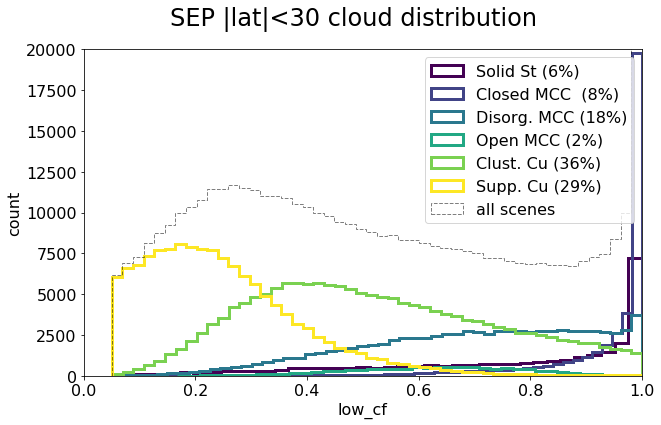

In [6]:
utils.plot_dataframe_by_cat(sub_df_trop, 'low_cf', scale_factor=1, xlims=[0,1], xlabel=None, savename=None,
                           cert_thresh=None, verbose=False, hist=True, label_pct=True, ylims=(0, 2e4),
                           normed=False)
plt.suptitle('SEP |lat|<30 cloud distribution')

In [137]:
means = {int(i): np.nanmean(by_cat.get_group(i).low_cf) for i in by_cat.groups.keys()}
freqs = {int(i): sum(~np.isnan(by_cat.get_group(i).low_cf))/len(sub_df) for i in by_cat.groups.keys()}
MADs = {int(i): (by_cat.get_group(i).low_cf).mad() for i in by_cat.groups.keys()}
MADs_remainder = {int(i): sub_df.low_cf[~(sub_df.cat == i)].mad() for i in by_cat.groups.keys()}
stds = {int(i): (by_cat.get_group(i).low_cf).std() for i in by_cat.groups.keys()}
stds_remainder = {int(i): sub_df.low_cf[~(sub_df.cat == i)].std() for i in by_cat.groups.keys()}
mean_mad = sub_df.low_cf.mad()
mean_std = sub_df.low_cf.std()
mean_cf = np.nanmean(sub_df.low_cf)
perfect_model = sum([freqs[i]*MADs[i] for i in freqs.keys()])
perfect_model_std = sum([freqs[i]*stds[i] for i in freqs.keys()])
usefulness = {int(i): freqs[i]*MADs[i] + (1-freqs[i])*MADs_remainder[i] for i in freqs.keys()}
usefulness_std = {int(i): freqs[i]*stds[i] + (1-freqs[i])*stds_remainder[i] for i in freqs.keys()}
model_usefulness = (mean_mad-perfect_model)/mean_mad
model_usefulness_std = (mean_std-perfect_model_std)/mean_std
category_usefulness = {labels[i]: (mean_mad-usefulness[i])/mean_mad for i in usefulness.keys()}
category_usefulness_std = {labels[i]: (mean_std-usefulness_std[i])/mean_std for i in usefulness_std.keys()}

In [110]:
mean_std, perfect_model_std, f"perfect model err. reduction:{ model_usefulness_std:0.0%}"

(0.29244964632744913, 0.17926543491684496, 'perfect model err. reduction:39%')

In [111]:
mean_mad, perfect_model, f"perfect model err. reduction:{ model_usefulness:0.0%}"

(0.25655781093854546, 0.14449083817239505, 'perfect model err. reduction:44%')

In [114]:
category_usefulness, category_usefulness_std

({'Closed-cellular MCC': 0.1354124241932138,
  'Clustered cumulus': 0.021590597582537098,
  'Disorganized MCC': 0.019922124293669248,
  'Open-cellular MCC': 0.0006552290910104753,
  'Solid Stratus': 0.08251862360354585,
  'Suppressed Cu': 0.2587713195407104},
 {'Closed-cellular MCC': 0.1166269130389649,
  'Clustered cumulus': 0.021974953013545077,
  'Disorganized MCC': 0.023733722972476102,
  'Open-cellular MCC': 0.0058485493224796035,
  'Solid Stratus': 0.06485338383244325,
  'Suppressed Cu': 0.23640168969143535})

In [119]:
sum(category_usefulness_std.values())

0.4694392118713443

In [116]:
freqs, usefulness

({0: 0.12981128532764113,
  1: 0.3034888188069853,
  2: 0.17848526735916811,
  3: 0.040150507270276914,
  4: 0.1358258938222102,
  5: 0.21223822741371834},
 {0: 0.2218166958136528,
  1: 0.2510185744859147,
  2: 0.25144663434051606,
  3: 0.25638970679729256,
  4: 0.23538701350515795,
  5: 0.19016800766350195})